In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Imputation
#from sklearn.impute import SimpleImputer, KNNImputer

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

# Machine-learning stack
#from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier 
#from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score
#from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
#from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier
#from sklearn.decomposition import PCA
#from scipy.stats import boxcox, yeojohnson
import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50V2, EfficientNetB0, EfficientNetB5, EfficientNetB7, DenseNet121, ResNet152V2
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D

## Pipeline
from sklearn.compose import ColumnTransformer
from keras.models import load_model, Model
#from sklearn.pipeline import make_pipeline, Pipeline
#from imblearn.pipeline import Pipeline as ImbPipeline

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPU detected.")

No GPU detected.


# Feature Engineering

New features can be created by combining the existing ones in a meaninfull way. The new features are taken from the following notebook:

https://www.kaggle.com/code/vyacheslavbolotin/isic-2024-only-tabular-data-new-features

In [4]:
# Read the dataset
ROOT_DATASET_DIR = "./"
file_name = os.path.join(ROOT_DATASET_DIR,"train-metadata-eda.csv")
df_eda = pd.read_csv(file_name)
#df_eda.drop(columns=['Unnamed: 0', 'isic_id', 'im_height'], inplace=True)

In [5]:
df_eda.columns

Index(['isic_id', 'target', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext',
       'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H',
       'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'log_clin_size_long_diam_mm',
       'log_tbp_lv_areaMM2', 'log_tbp_lv_area_perim_ratio',
       'log_tbp_lv_color_std_mean', 'log_tbp_lv_deltaLB',
       'log_tbp_lv_deltaLBnorm', 'l

In [16]:
print_NaNs(df_eda)

The dataframe contains no NaN values


In [6]:
# Create new features
n_rows = df_eda.shape[0]
# err = 1e-5

new_cols = [
    'lesion_size_ratio',                 # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',                # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                      # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',                # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',           # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',                 # tbp_lv_norm_border      + tbp_lv_symm_2axis
    #'color_uniformity',                  # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',              # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',           # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',           # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',           # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',       # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',       # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',                 # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',                 # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',              # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',         # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',             # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',            # border_complexity       + lesion_shape_index
    'color_contrast_index',              # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',                   # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',            # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',               # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',                  # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',       # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',             # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',          # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',    # tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',        # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',              # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',          # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',         # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',    # tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',             # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',           # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                       # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',           # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',               # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',           # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',           # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]
# Initialize a DataFrame with zeros
df_nf = pd.DataFrame(np.zeros((n_rows, len(new_cols))), columns=new_cols)

# Calculate the new features
df_nf['lesion_size_ratio'] = df_eda['tbp_lv_minorAxisMM'] / df_eda['clin_size_long_diam_mm']
df_nf['lesion_shape_index'] = df_eda['tbp_lv_areaMM2'] / (df_eda['tbp_lv_perimeterMM'] ** 2)
df_nf['hue_contrast'] = (df_eda['tbp_lv_H'] - df_eda['tbp_lv_Hext']).abs()
df_nf['luminance_contrast'] = (df_eda['tbp_lv_L'] - df_eda['tbp_lv_Lext']).abs()
df_nf['lesion_color_difference'] = (df_eda['tbp_lv_deltaA'] ** 2 + df_eda['tbp_lv_deltaB'] ** 2 + df_eda['tbp_lv_deltaL'] ** 2).pow(0.5)
df_nf['border_complexity'] = df_eda['tbp_lv_norm_border'] + df_eda['tbp_lv_symm_2axis']
#df_nf['color_uniformity'] = df_eda['tbp_lv_color_std_mean'] / (df_eda['tbp_lv_radial_color_std_max'] + err)

df_nf['position_distance_3d'] = (df_eda['tbp_lv_x'] ** 2 + df_eda['tbp_lv_y'] ** 2 + df_eda['tbp_lv_z'] ** 2).pow(0.5)
df_nf['perimeter_to_area_ratio'] = df_eda['tbp_lv_perimeterMM'] / df_eda['tbp_lv_areaMM2']
df_nf['area_to_perimeter_ratio'] = df_eda['tbp_lv_areaMM2'] / df_eda['tbp_lv_perimeterMM']
df_nf['lesion_visibility_score'] = df_eda['tbp_lv_deltaLBnorm'] + df_eda['tbp_lv_norm_color']
#df_nf['combined_anatomical_site'] = df_eda['anatom_site_general'] + '_' + df_eda['tbp_lv_location']
df_nf['symmetry_border_consistency'] = df_eda['tbp_lv_symm_2axis'] * df_eda['tbp_lv_norm_border']
df_nf['consistency_symmetry_border'] = df_eda['tbp_lv_symm_2axis'] * df_eda['tbp_lv_norm_border'] / (df_eda['tbp_lv_symm_2axis'] + df_eda['tbp_lv_norm_border'])

df_nf['color_consistency'] = df_eda['tbp_lv_stdL'] / df_eda['tbp_lv_Lext']
df_nf['consistency_color'] = df_eda['tbp_lv_stdL'] * df_eda['tbp_lv_Lext'] / (df_eda['tbp_lv_stdL'] + df_eda['tbp_lv_Lext'])
df_nf['size_age_interaction'] = df_eda['clin_size_long_diam_mm'] * df_eda['age_approx']
df_nf['hue_color_std_interaction'] = df_eda['tbp_lv_H'] * df_eda['tbp_lv_color_std_mean']
df_nf['lesion_severity_index'] = (df_eda['tbp_lv_norm_border'] + df_eda['tbp_lv_norm_color'] + df_eda['tbp_lv_eccentricity']) / 3
df_nf['shape_complexity_index'] = df_nf['border_complexity'] + df_nf['lesion_shape_index']
df_nf['color_contrast_index'] = df_eda['tbp_lv_deltaA'] + df_eda['tbp_lv_deltaB'] + df_eda['tbp_lv_deltaL'] + df_eda['tbp_lv_deltaLBnorm']

df_nf['log_lesion_area'] = (df_eda['tbp_lv_areaMM2'] + 1).apply(np.log)
df_nf['normalized_lesion_size'] = df_eda['clin_size_long_diam_mm'] / df_eda['age_approx']
df_nf['mean_hue_difference'] = (df_eda['tbp_lv_H'] + df_eda['tbp_lv_Hext']) / 2
df_nf['std_dev_contrast'] = ((df_eda['tbp_lv_deltaA'] ** 2 + df_eda['tbp_lv_deltaB'] ** 2 + df_eda['tbp_lv_deltaL'] ** 2) / 3).pow(0.5)
df_nf['color_shape_composite_index'] = (df_eda['tbp_lv_color_std_mean'] + df_eda['tbp_lv_area_perim_ratio'] + df_eda['tbp_lv_symm_2axis']) / 3
df_nf['lesion_orientation_3d'] = np.arctan2(df_eda['tbp_lv_y'], df_eda['tbp_lv_x'])
df_nf['overall_color_difference'] = (df_eda['tbp_lv_deltaA'] + df_eda['tbp_lv_deltaB'] + df_eda['tbp_lv_deltaL']) / 3

df_nf['symmetry_perimeter_interaction'] = df_eda['tbp_lv_symm_2axis'] * df_eda['tbp_lv_perimeterMM']
df_nf['comprehensive_lesion_index'] = (df_eda['tbp_lv_area_perim_ratio'] + df_eda['tbp_lv_eccentricity'] + df_eda['tbp_lv_norm_color'] + df_eda['tbp_lv_symm_2axis']) / 4
df_nf['color_variance_ratio'] = df_eda['tbp_lv_color_std_mean'] / df_eda['tbp_lv_stdLExt']
df_nf['border_color_interaction'] = df_eda['tbp_lv_norm_border'] * df_eda['tbp_lv_norm_color']
df_nf['border_color_interaction_2'] = df_eda['tbp_lv_norm_border'] * df_eda['tbp_lv_norm_color'] / (df_eda['tbp_lv_norm_border'] + df_eda['tbp_lv_norm_color'])
df_nf['size_color_contrast_ratio'] = df_eda['clin_size_long_diam_mm'] / df_eda['tbp_lv_deltaLBnorm']
df_nf['age_normalized_nevi_confidence'] = df_eda['tbp_lv_nevi_confidence'] / df_eda['age_approx']
df_nf['age_normalized_nevi_confidence_2'] = (df_eda['clin_size_long_diam_mm']**2 + df_eda['age_approx']**2).pow(0.5)
df_nf['color_asymmetry_index'] = df_eda['tbp_lv_radial_color_std_max'] * df_eda['tbp_lv_symm_2axis']

df_nf['volume_approximation_3d'] = df_eda['tbp_lv_areaMM2'] * (df_eda['tbp_lv_x']**2 + df_eda['tbp_lv_y']**2 + df_eda['tbp_lv_z']**2).pow(0.5)
df_nf['color_range'] = (df_eda['tbp_lv_L'] - df_eda['tbp_lv_Lext']).abs() + (df_eda['tbp_lv_A'] - df_eda['tbp_lv_Aext']).abs() + (df_eda['tbp_lv_B'] - df_eda['tbp_lv_Bext']).abs()
df_nf['shape_color_consistency'] = df_eda['tbp_lv_eccentricity'] * df_eda['tbp_lv_color_std_mean']
df_nf['border_length_ratio'] = df_eda['tbp_lv_perimeterMM'] / (2 * np.pi * (df_eda['tbp_lv_areaMM2'] / np.pi).pow(0.5))
df_nf['age_size_symmetry_index'] = df_eda['age_approx'] * df_eda['clin_size_long_diam_mm'] * df_eda['tbp_lv_symm_2axis']
df_nf['index_age_size_symmetry'] = df_eda['age_approx'] * df_eda['tbp_lv_areaMM2'] * df_eda['tbp_lv_symm_2axis']


In [17]:
df_nf[df_nf.isna().any(axis=1)]

,lesion_size_ratio,lesion_shape_index,hue_contrast,luminance_contrast,lesion_color_difference,border_complexity,position_distance_3d,perimeter_to_area_ratio,area_to_perimeter_ratio,lesion_visibility_score,...,size_color_contrast_ratio,age_normalized_nevi_confidence,age_normalized_nevi_confidence_2,color_asymmetry_index,volume_approximation_3d,color_range,shape_color_consistency,border_length_ratio,age_size_symmetry_index,index_age_size_symmetry


In [7]:
# Analize the skewness.
# This fuction applies, for each feature, different transforms for correcting skeweness and returns
# a dataframe with the results. Ideally a data distribution should have a skewness score close to 0.
# Good skeness score are around +- 0.5
def analyze_skewness(df):

    # Obtain the list of the column names
    num_features = list(df.columns[(df.dtypes != object) & (df.dtypes != 'category')])
    # num_features.remove('target')
    
    # Define the number of rows and columns
    num_rows = len(num_features)
    columns = ['Feature', 'ORIG', 'LOG', 'EXP', 'SQR', 'RSQR']

    # Initialize the dataframe with zeros
    df_stats = pd.DataFrame(np.zeros((num_rows, len(columns))), columns=columns)

    # Loop over features
    for idx, feature in enumerate(num_features):

        tr_log = ColumnTransformer(transformers=[("log", FunctionTransformer(np.log1p), [feature])])
        tr_exp = ColumnTransformer(transformers=[("exp", FunctionTransformer(np.exp), [feature])])                
        tr_sqr = ColumnTransformer(transformers=[("sqr", FunctionTransformer(np.square), [feature])])    
        #tr_cube = ColumnTransformer(transformers=[("cube", FunctionTransformer(lambda x: x**3), [feature])])
        tr_sqrt = ColumnTransformer(transformers=[("sqrt", FunctionTransformer(np.sqrt), [feature])])
        #tr_bxx = ColumnTransformer(transformers=[("bxx", FunctionTransformer(add_one_and_boxcox), [feature])])
    
        df_log = pd.DataFrame(tr_log.fit_transform(df))
        df_exp = pd.DataFrame(tr_exp.fit_transform(df))
        df_sqr = pd.DataFrame(tr_sqr.fit_transform(df))
        df_sqrt = pd.DataFrame(tr_sqrt.fit_transform(df))
        #df_bxx = pd.DataFrame(tr_bxx.fit_transform(df))
        
        df_stats.iloc[idx,0] = feature
        df_stats.iloc[idx,1] = round(df[feature].skew(),1)
        df_stats.iloc[idx,2] = round(df_log.skew()[0],1)
        df_stats.iloc[idx,3] = round(df_exp.skew()[0],1)
        df_stats.iloc[idx,4] = round(df_sqr.skew()[0],1)
        df_stats.iloc[idx,5] = round(df_sqrt.skew()[0],1)
        #df_stats.iloc[idx,6] = round(df_bxx.skew()[0],1)

    return pd.DataFrame(df_stats).set_index('Feature')

In [8]:
analyze_skewness(df_nf)

,ORIG,LOG,EXP,SQR,RSQR
Feature,,,,,
lesion_size_ratio,-0.0,-0.2,0.2,0.4,-0.3
lesion_shape_index,-0.6,-0.6,-0.5,-0.1,-0.8
hue_contrast,2.0,-0.2,617.3,5.5,0.6
luminance_contrast,1.2,0.3,607.8,2.6,0.7
lesion_color_difference,1.3,0.3,491.7,2.9,0.7
border_complexity,1.1,0.4,10.4,2.2,0.6
position_distance_3d,-0.7,-1.3,NaN,-0.2,-1.0
perimeter_to_area_ratio,0.5,-0.2,10.2,1.6,-0.1
area_to_perimeter_ratio,2.3,1.4,7.4,5.4,1.3


In [9]:
# According to the above table, the following features require log transform and square transform to correct skewness.
# Note that the features with negative values will not be transformed in order not to loose information (negative sign)
new_features_to_be_logtr = ['hue_contrast',
                            'luminance_contrast',
                            'lesion_color_difference',
                            'border_complexity',
                            #'color_uniformity',
                            'perimeter_to_area_ratio',
                            'area_to_perimeter_ratio',
                            'lesion_visibility_score',
                            'symmetry_border_consistency',
                            'consistency_symmetry_border',
                            #'color_consistency',
                            'consistency_color',
                            'size_age_interaction',
                            'lesion_severity_index',
                            'shape_complexity_index',
                            #'normalized_lesion_size',
                            'std_dev_contrast',
                            'color_shape_composite_index',
                            'symmetry_perimeter_interaction',
                            'comprehensive_lesion_index',
                            #'color_variance_ratio',
                            'border_color_interaction',
                            'size_color_contrast_ratio',
                            'age_normalized_nevi_confidence',
                            #'color_asymmetry_index',
                            'volume_approximation_3d',
                            'color_range',
                            #'shape_color_consistency',
                            'age_size_symmetry_index',
                            'index_age_size_symmetry']
new_features_to_be_sqrtr = ['lesion_shape_index',
                            'position_distance_3d']
new_features_to_be_sqrttr = ['color_consistency',
                             'hue_color_std_interaction',
                             'normalized_lesion_size',
                             #'overall_color_difference',
                             'color_variance_ratio',
                             'color_asymmetry_index',
                             'shape_color_consistency']

# Let's apply
df_log_new_features = df_nf[new_features_to_be_logtr].apply(lambda x : np.log1p(x))
df_sqr_new_features = df_nf[new_features_to_be_sqrtr].apply(lambda x : np.square(x))
df_sqrt_new_features = df_nf[new_features_to_be_sqrttr].apply(lambda x : np.sqrt(x))

# Modify the column names
df_log_new_features.columns = ['log_' + col for col in new_features_to_be_logtr]
df_sqr_new_features.columns = ['sqr_' + col for col in new_features_to_be_sqrtr]
df_sqrt_new_features.columns = ['sqrt_' + col for col in new_features_to_be_sqrttr]


In [18]:

def plot_num_comp(df1, df2, feature, label1='', label2=''):
    feature1 = label1 + feature
    feature2 = label2 + feature
    print(feature1)
    fig = plt.figure(figsize=(20,2))
    axes = fig.add_subplot(141)    
    #,axes=plt.subplots(1,2)    
    sns.boxplot(data=df1, x=feature1, ax=axes)    
    #plt.xlabel(units)  
    axes = fig.add_subplot(142)
    sns.histplot(data=df1, x=feature1, ax=axes, color='#D0312D', kde=True)
    #plt.xlabel(units)
    axes = fig.add_subplot(143)    
    #,axes=plt.subplots(1,2)    
    sns.boxplot(data=df2, x=feature2, ax=axes)    
    #plt.xlabel(units)  
    axes = fig.add_subplot(144)
    sns.histplot(data=df2, x=feature2, ax=axes, color='green', kde=True)
    #plt.xlabel(units)
    fig.set_size_inches(20, 2)
    #plt.suptitle(label + feature)  # Adds a title to the entire figure
    plt.show()

# Visualize the processed data with log and sqr
#for idx, column in enumerate(log_tr_features):
#    plot_num_comp(df_nf, df_log_features, column, label2='log_')
#for idx, column in enumerate(sqr_tr_features):
#    plot_num_comp(df_nf, df_sqr_features, column, label2='sqr_')
#for idx, column in enumerate(sqrt_tr_features):
#    plot_num_comp(df_nf, df_sqrt_features, column, label2='sqrt_')        

In [19]:
# Function to print NaN values only
def print_NaNs(df):
    nan_list = df.isna().sum()
    if nan_list.sum() == 0:
        print("The dataframe contains no NaN values")
    else:
        return nan_list[nan_list != 0]

print_NaNs(df_sqrt_new_features)


The dataframe contains no NaN values


In [20]:
# Final dataframe

df_eda_fe = pd.concat([df_eda, df_nf, df_log_new_features, df_sqr_new_features, df_sqrt_new_features], axis=1)

print(f"Colums df_eda_all: {df_eda.shape[1]}")
print(f"Colums df_eda_all + fe (log + sqr + sqrt): {df_eda_fe.shape[1]}")

#df_eda_fe.to_csv("train-metadata-eda-fe.csv", index=False)

Colums df_eda_all: 56
Colums df_eda_all + fe (log + sqr + sqrt): 129


In [21]:
# Function to print NaN values only
def print_NaNs(df):
    nan_list = df.isna().sum()
    if nan_list.sum() == 0:
        print("The dataframe contains no NaN values")
    else:
        return nan_list[nan_list != 0]

print_NaNs(df_eda_fe)

The dataframe contains no NaN values


# Extract Pixel-based Features from the CNN

In [12]:
# Parameters
BATCH_SIZE = 64
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IM_SIZE = 128

# Read the dataset
DATASET = os.path.join("..","images_old","all")

In [13]:
# Function for custom normalization
def custom_normalization(image):
    image = image / 255.0
    mean = tf.constant(MEAN, dtype=image.dtype)
    std = tf.constant(STD, dtype=image.dtype)
    image = (image - mean) / std  # Normalize each channel
    return image
    
# Parse and process images
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IM_SIZE, IM_SIZE]) #, method=tf.image.ResizeMethod.LANCZOS3)
    image = custom_normalization(image)
    return image, label

# Generate dataset from file paths
def generate_dataset(file_paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# List image paths and labels
def get_image_paths_and_labels(directory):
    data_dir = Path(directory)   
    all_image_paths = list(data_dir.glob('*/*.jpg'))
    all_image_paths = [str(path) for path in all_image_paths]    
    all_labels = [10 for path in all_image_paths]
    return all_image_paths, all_labels

# All dataset
all_paths, all_labels = get_image_paths_and_labels(DATASET)
all_dataset = generate_dataset(all_paths, all_labels, BATCH_SIZE)

In [14]:
len(all_paths), len(all_labels)

(395303, 395303)

In [15]:
# Load CNN
# Read the dataset
ROOT_DATASET_DIR = "../"
MODELS = os.path.join(ROOT_DATASET_DIR,"models")
#model = load_model('../models/rn152v2_nn256_lr0001_relu_batch64_epoch50_v34_final.keras')
#model = load_model(os.path.join(MODELS,"dn121_nn256_lr0001_relu_batch64_epoch100_v51_final.keras"))
model = load_model(os.path.join(MODELS,"rn152v2_nn256x128x64_lr0001_relu_batch64_epoch50_v1_final.keras"))
feature_extractor_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Use this model to extract features from your images
features = feature_extractor_model.predict(all_dataset)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9
6177/6177 [==============================] - 209s 32ms/step


In [16]:
# Create the dataframe
GET_IMG_NAME = re.compile(r"ISIC_[0-9]{1,7}")
df_img_features = pd.DataFrame(features)
df_img_features.columns = ['im_feature_' + str(col) for col in df_img_features.columns]
df_img_features['isic_id'] = df_eda['isic_id']
df_img_features['image_path'] = all_paths
df_img_features['image_name'] = df_img_features['image_path'].apply(lambda x: GET_IMG_NAME.search(x).group() if GET_IMG_NAME.search(x) else None)
df_img_features.drop(columns=['image_path'], inplace=True)

# Check that the features extracted from the CNN really correspond to the image of the patient.
if (df_img_features.isic_id == df_img_features.image_name).sum() == df_img_features.shape[0]:
    print(f"Removing isic_id and image_name columns")
    df_img_features.drop(columns=['isic_id','image_name'], inplace=True)

# Remove those columns where all values are 0
df_img_features = df_img_features.loc[:, (df_img_features != 0).any(axis=0)]

Removing isic_id and image_name columns


In [17]:
# Add target
if df_img_features.shape[0] == df_eda.shape[0]:
    print(f"Ready to concatenate the target column")
    df_img_features = pd.concat([df_img_features, df_eda['target']], axis=1)

Ready to concatenate the target column


In [18]:
df_img_features.head()

,im_feature_0,im_feature_1,im_feature_2,im_feature_3,im_feature_4,im_feature_5,im_feature_6,im_feature_7,im_feature_8,im_feature_9,...,im_feature_55,im_feature_56,im_feature_57,im_feature_58,im_feature_59,im_feature_60,im_feature_61,im_feature_62,im_feature_63,target
0,0.0,0.0,4.785156,3.298828,0.0,0.0,0.0,0.0,5.339844,3.875000,...,2.363281,6.308594,0.0,0.0,0.832031,2.626953,3.841797,2.242188,0.0,0
1,0.0,0.0,4.164062,2.960938,0.0,0.0,0.0,0.0,5.148438,3.353516,...,2.197266,5.421875,0.0,0.0,0.688477,2.224609,2.884766,1.666992,0.0,0
2,0.0,0.0,5.328125,3.507812,0.0,0.0,0.0,0.0,6.089844,4.355469,...,2.775391,6.718750,0.0,0.0,1.070312,2.955078,3.876953,2.416016,0.0,0
3,0.0,0.0,5.152344,3.414062,0.0,0.0,0.0,0.0,5.664062,4.066406,...,2.546875,6.394531,0.0,0.0,0.918945,2.779297,3.802734,2.271484,0.0,0
4,0.0,0.0,4.535156,2.875000,0.0,0.0,0.0,0.0,5.007812,3.626953,...,2.330078,5.574219,0.0,0.0,0.881348,2.488281,3.332031,2.027344,0.0,0


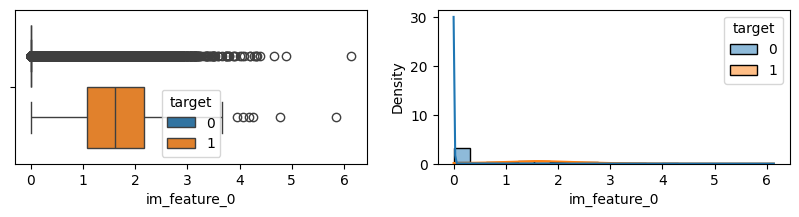

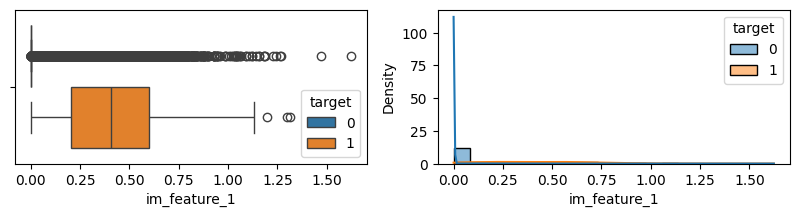

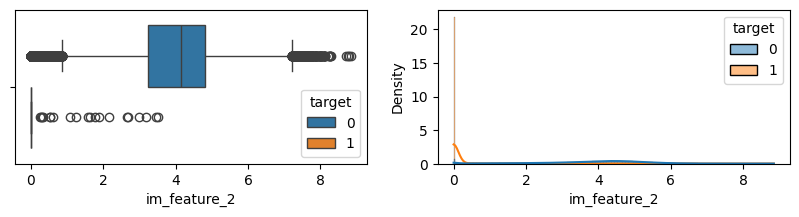

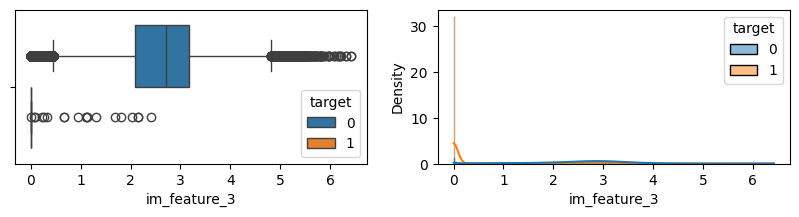

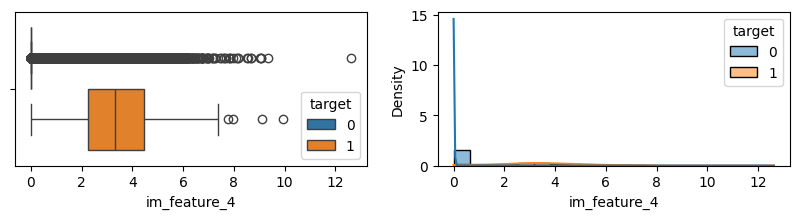

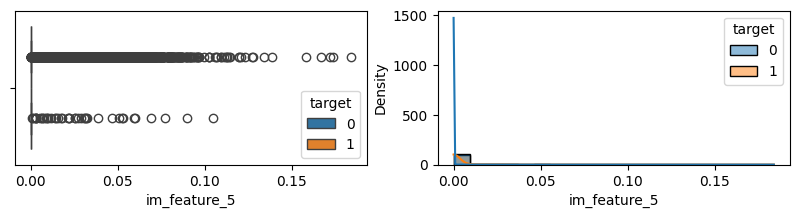

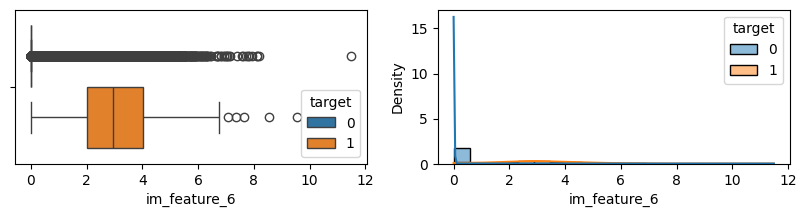

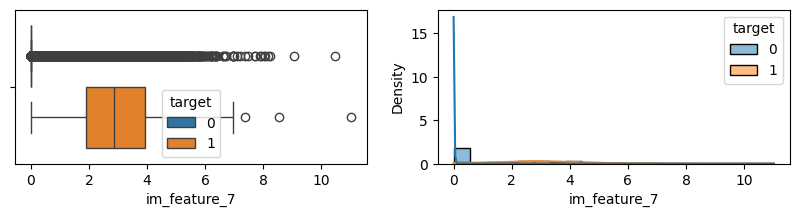

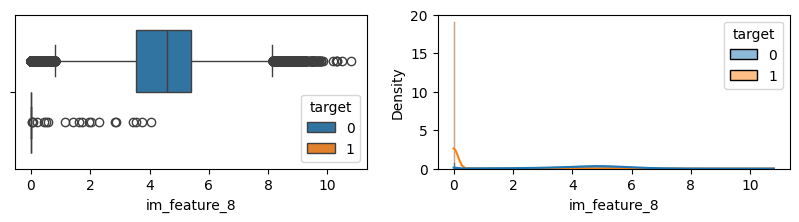

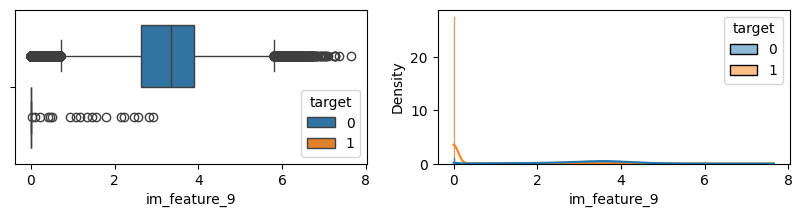

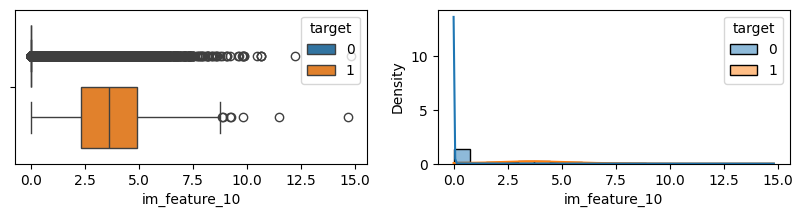

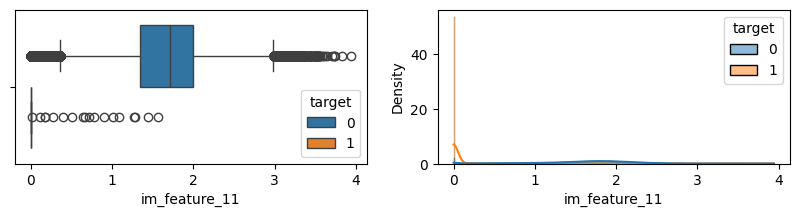

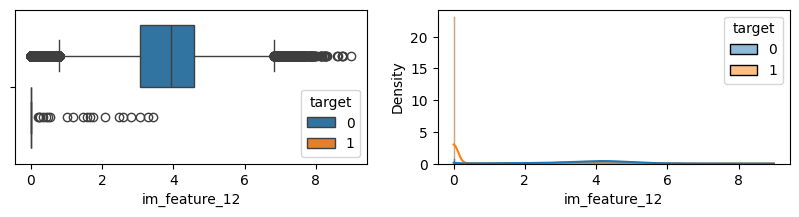

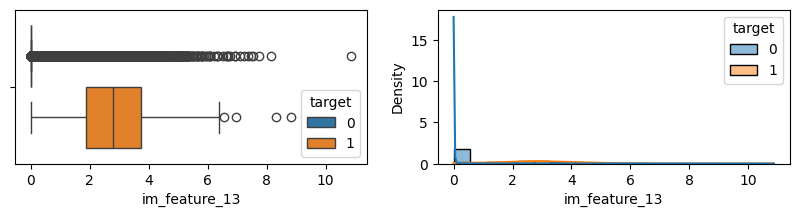

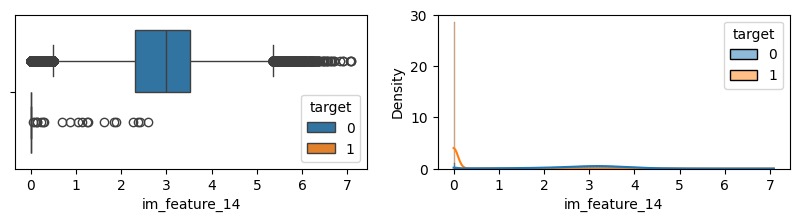

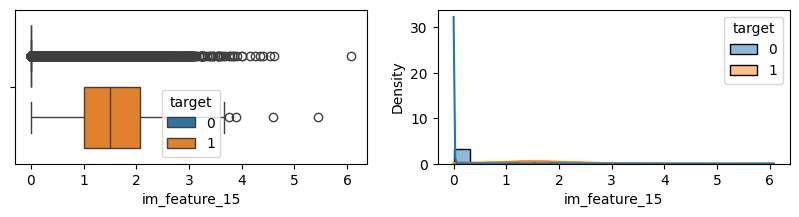

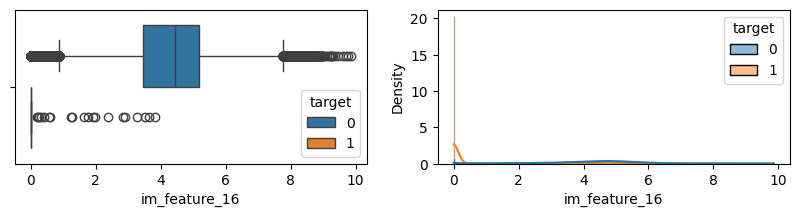

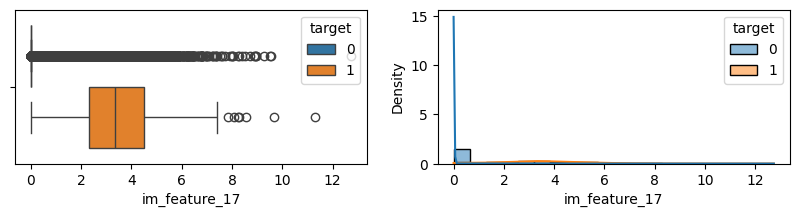

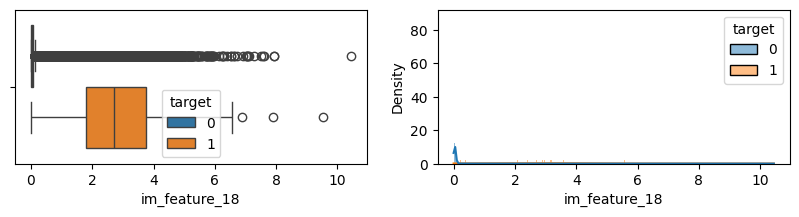

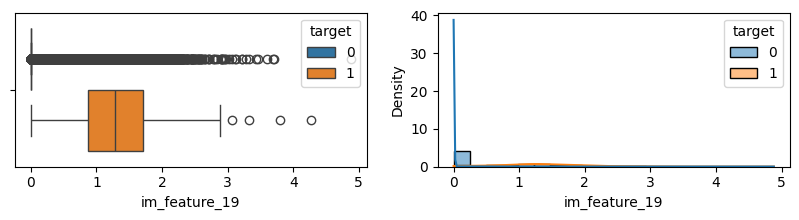

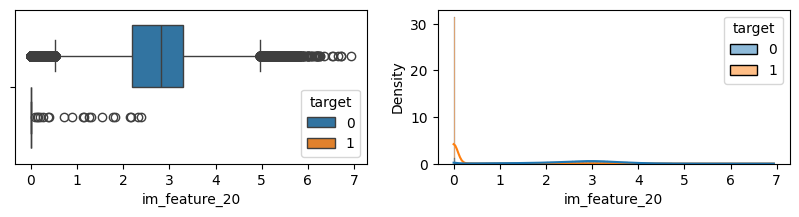

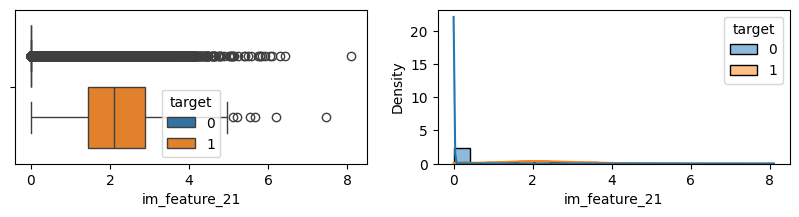

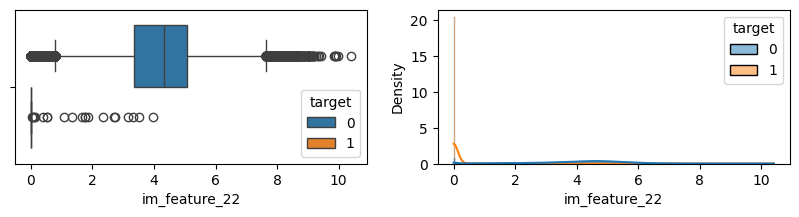

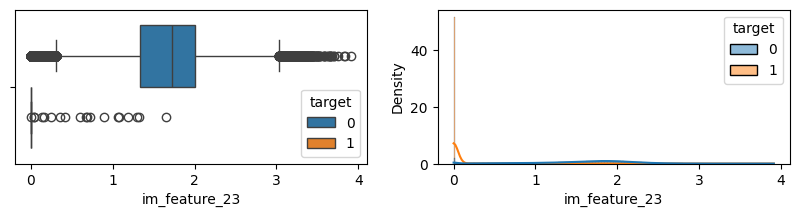

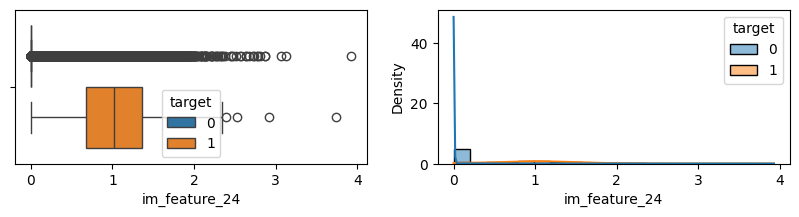

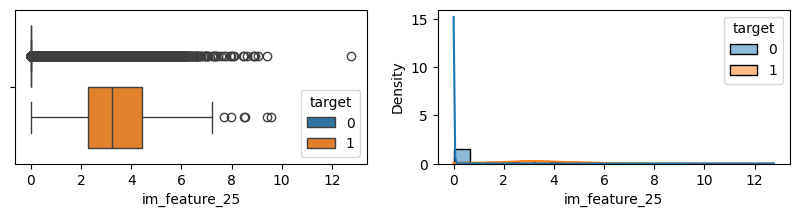

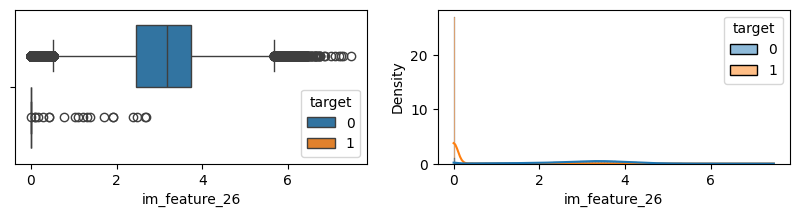

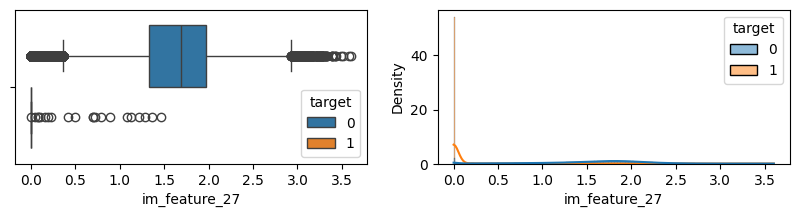

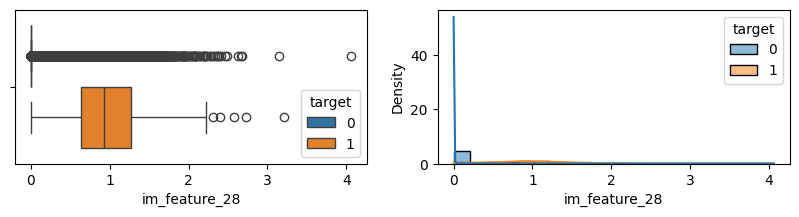

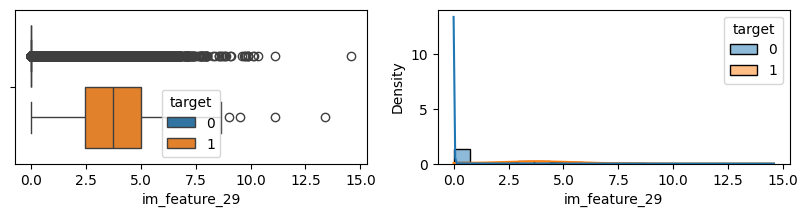

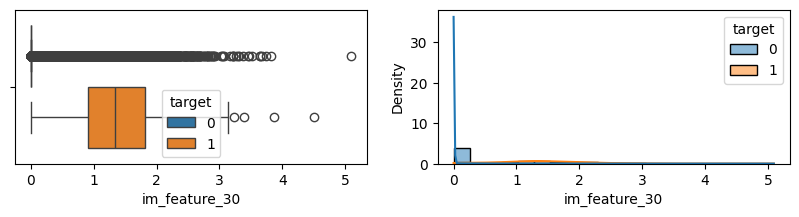

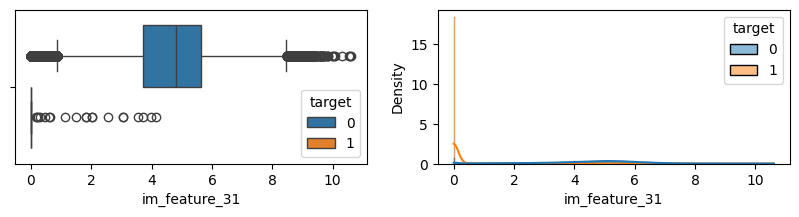

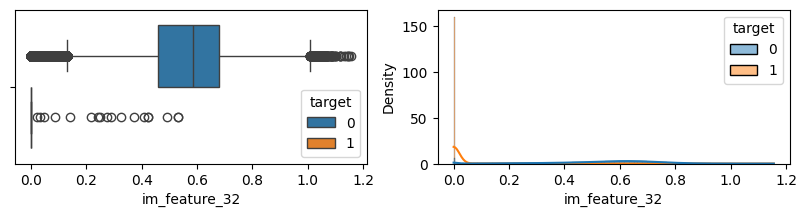

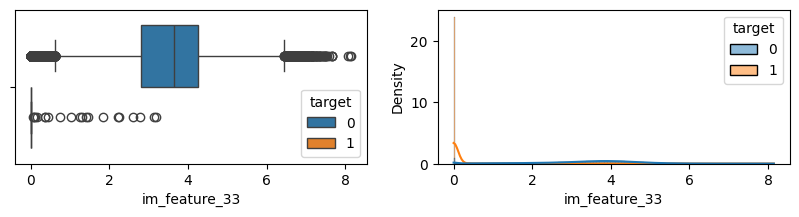

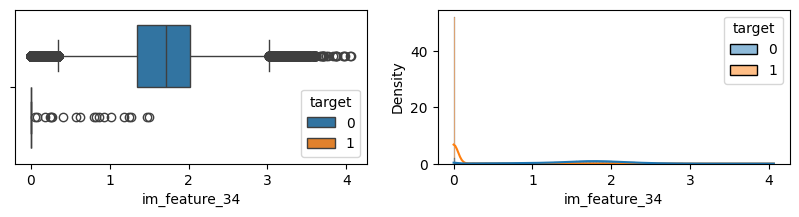

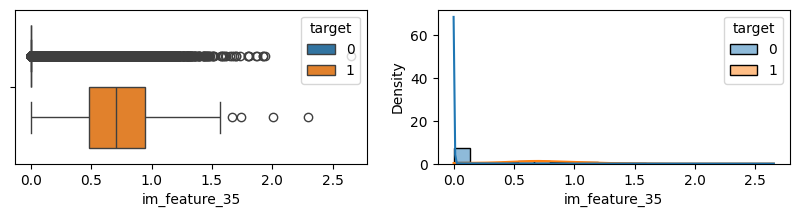

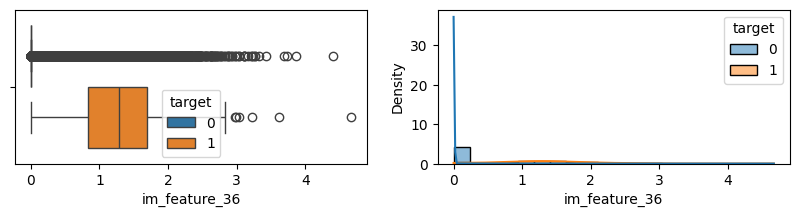

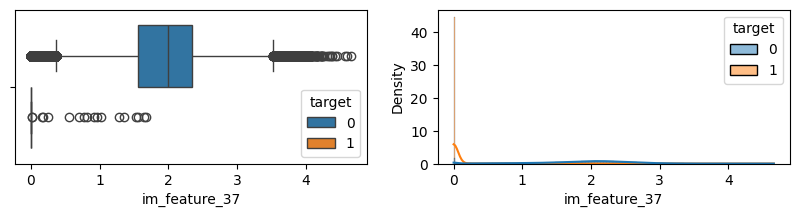

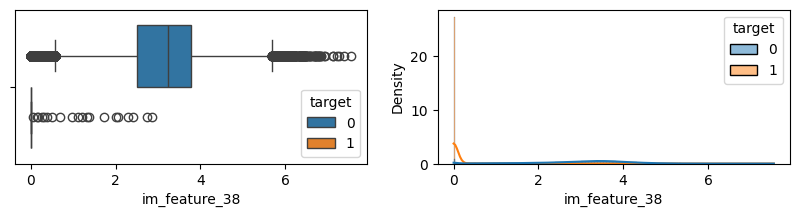

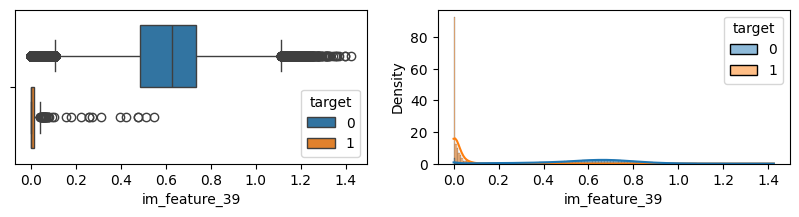

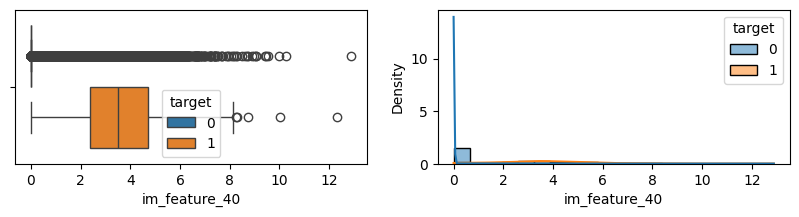

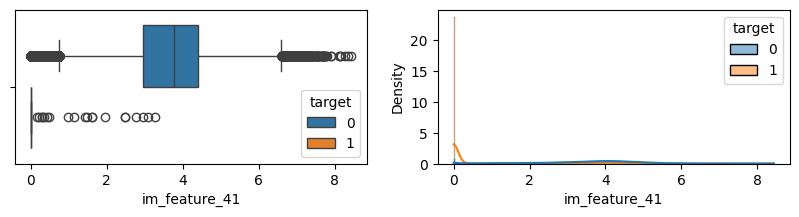

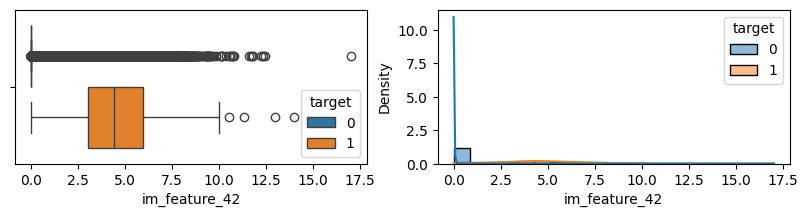

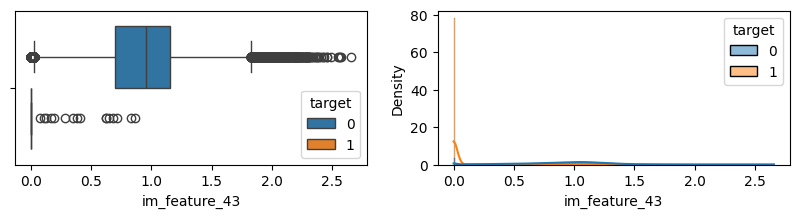

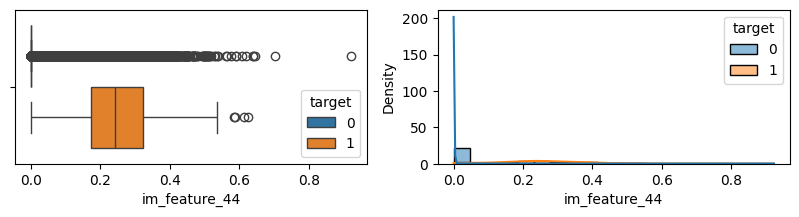

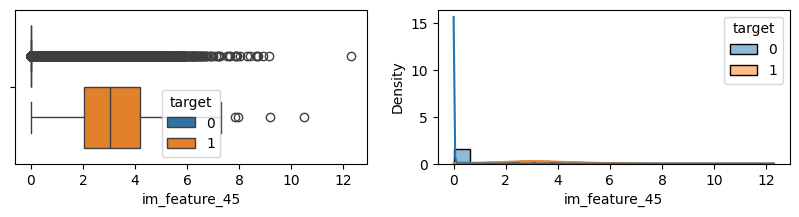

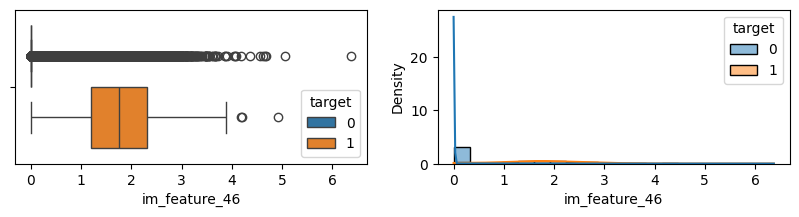

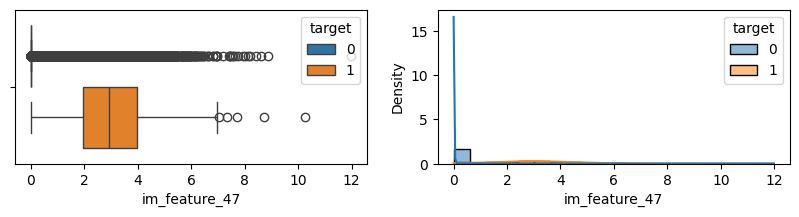

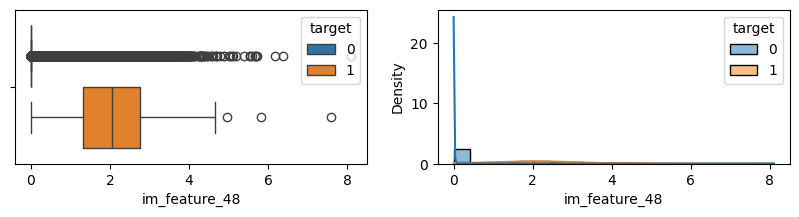

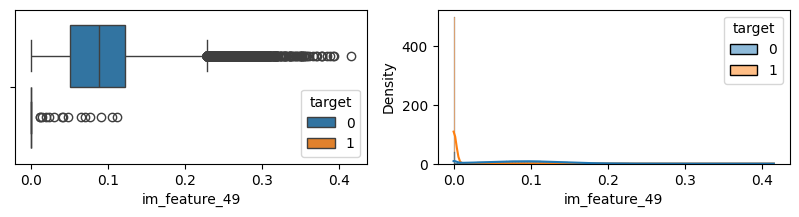

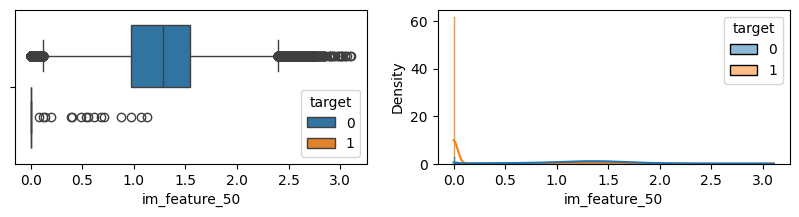

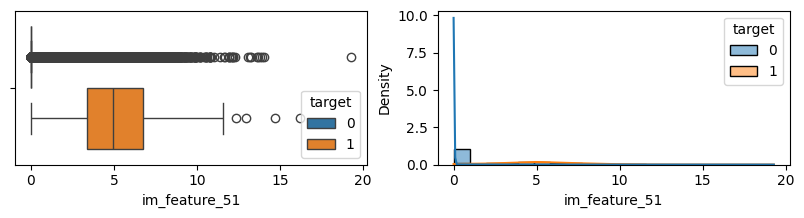

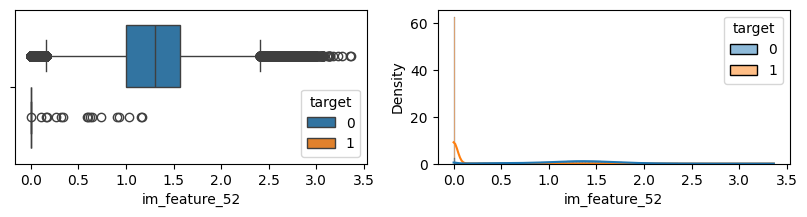

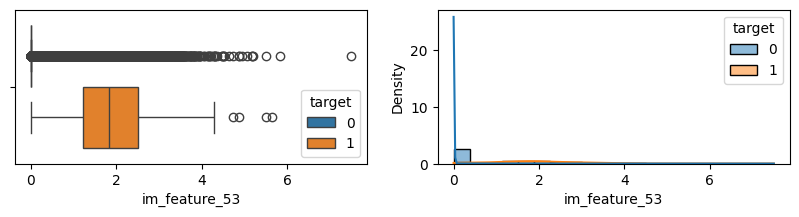

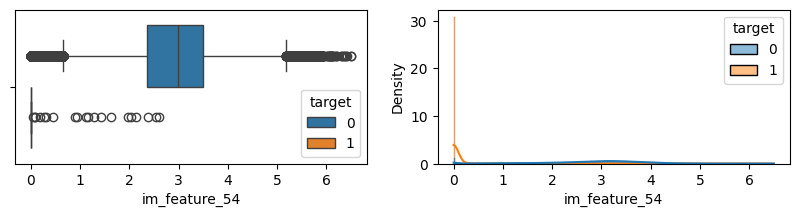

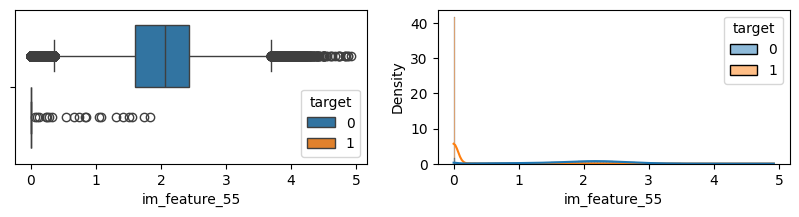

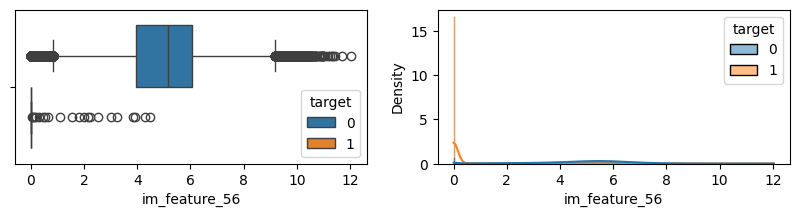

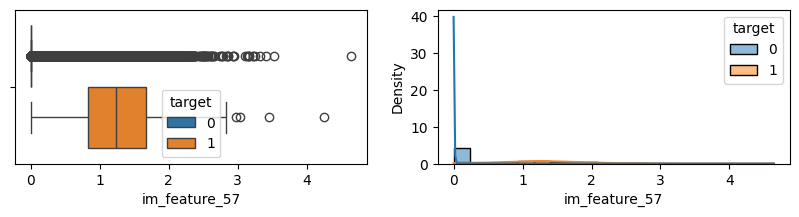

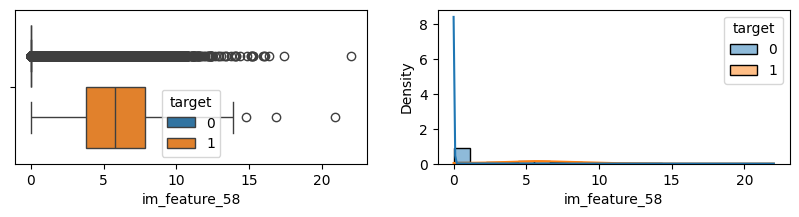

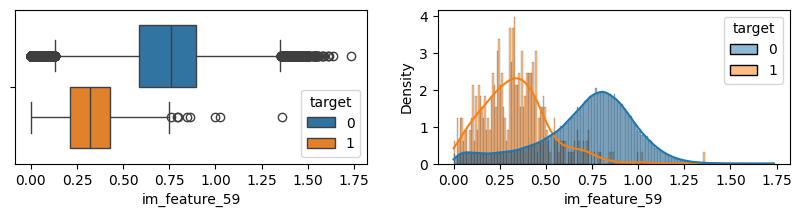

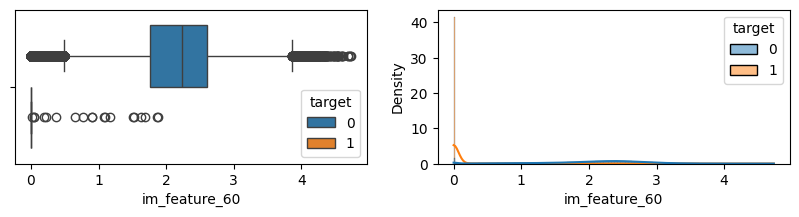

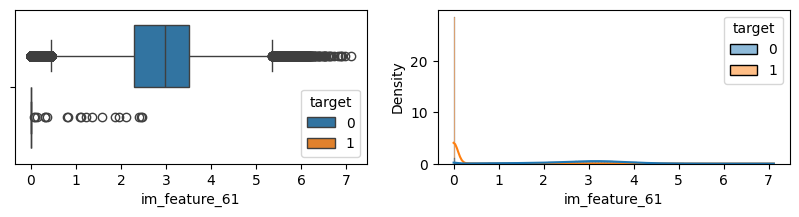

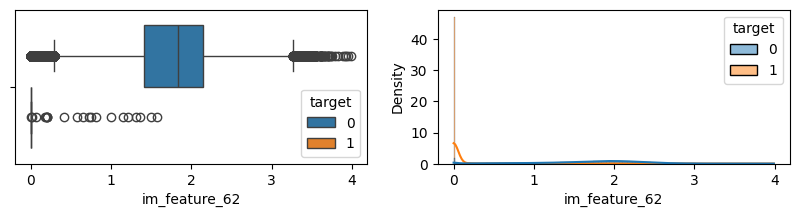

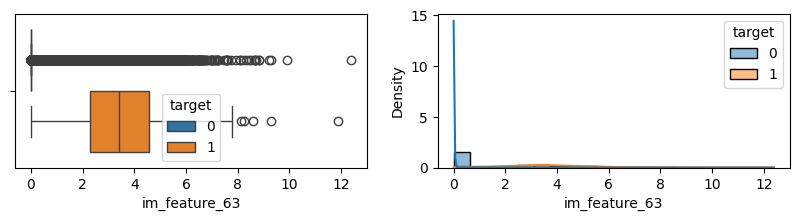

In [25]:
numerical_features = list(df_img_features.columns)
numerical_features.remove('target')

def plot_num(df, feature, label=''):
    feature = label + feature
    fig = plt.figure(figsize=(10,2))
    axes = fig.add_subplot(121)    
    #,axes=plt.subplots(1,2)    
    sns.boxplot(data=df, x=feature, hue='target', ax=axes)    
    #plt.xlabel(units)  
    axes = fig.add_subplot(122)
    sns.histplot(data=df, x=feature, hue='target', ax=axes, color='#D0312D', kde=True)
    #plt.xlabel(units)
    fig.set_size_inches(10, 2)
    #plt.suptitle(label + feature)  # Adds a title to the entire figure
    plt.show()
    
for idx, column in enumerate(numerical_features):
    plot_num(df_img_features, column)

In [20]:
df_img_features.target.value_counts()

target
0    394910
1       393
Name: count, dtype: int64

In [21]:
# Dimensionality reduction
targets = df_eda['target']
Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
Kbest_numerical.fit(df_img_features[numerical_features], targets)

# Extract feature scores and p-values
scores = Kbest_numerical.scores_
pvalues = Kbest_numerical.pvalues_

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': numerical_features,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
KBEST_NUM = sorted_features.shape[0]
print(f"Number of relevant numerical features: {KBEST_NUM}\n")
print(sorted_features.set_index('Feature'))

Number of relevant numerical features: 64

                      Score        P-Value
Feature                                   
im_feature_28  38498.585095   0.000000e+00
im_feature_17  37569.500273   0.000000e+00
im_feature_10  37106.126752   0.000000e+00
im_feature_29  37098.386780   0.000000e+00
im_feature_19  36514.420894   0.000000e+00
...                     ...            ...
im_feature_50   2383.045186   0.000000e+00
im_feature_43   2235.723937   0.000000e+00
im_feature_49   1060.596031  2.467405e-232
im_feature_59    875.749445  2.981927e-192
im_feature_5     217.352657   3.523238e-49

[64 rows x 2 columns]


In [22]:
df_img_features.to_csv("train-cnn-features-rn152v2.csv", index=False)